# Import Libraries

In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import time

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

# Load Dataset

In [4]:
# Directories
data_dir = '../data'
processed_data_dir = f'{data_dir}/processed'

# Dataset name and path
dataset_name = 'rental_pricing_kl_selangor.csv'
dataset_path = f'{processed_data_dir}/{dataset_name}'

# Load dataframe
df = pd.read_csv(dataset_path)
df

,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,region,age,missing_parking,f_minimart,f_gymnasium,f_security,f_playground,f_swimming_pool,f_parking,f_lift,f_barbeque_area,f_multipurpose_hall,f_jogging_track,f_squash_court,f_sauna,f_club_house,f_tennis_court,missing_facilities,a_air_cond,a_cooking_allowed,a_washing_machine,a_near_ktm_lrt,a_internet,missing_amenities
0,4200,1700.0,1600.0,5,2,6,1842,2,1,2,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0
1,1700,1500.0,1250.0,2,1,2,743,1,1,4,0,1,1,1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,0
2,1550,1800.0,1650.0,1,1,1,700,2,1,6,0,0,1,1,1,1,1,1,0,1,0,0,0,0,0,0,1,1,1,1,0,0
3,1400,2000.0,1250.0,2,1,1,750,2,1,10,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0
4,2600,1800.0,1650.0,2,1,2,868,1,1,5,1,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10749,1200,1300.0,1650.0,2,1,2,780,2,0,15,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0
10750,885,1300.0,1600.0,3,2,2,1015,1,0,3,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0,1,0,0
10751,1500,1200.0,1650.0,2,2,1,455,2,0,5,0,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0
10752,1300,1325.0,1650.0,4,2,3,1427,1,0,6,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,0


# Helpers

In [102]:
fig_width, fig_height = 10, 10

# Calculates evaluation metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Scatter plot: Actual vs Predicted
def plot_predicted_vs_actual(y_true, y_pred):
    plt.figure(figsize=(fig_width, fig_height))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)   # Line of perfect prediction
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted')
    plt.show()

# Residual plot
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(fig_width, fig_height))
    sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws=dict(color="r"))
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

# Residual QQ plot
def plot_residual_qq(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(fig_width, fig_height))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')
    plt.grid()
    plt.show()

# Residual distribution plot
def plot_residual_distribution(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(fig_width, fig_height))
    sns.histplot(residuals, kde=True, bins=30, color='blue')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.title('Residuals Distribution')
    plt.show()

# Plots all
def plot_graphs(y_true, y_pred):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height))
    axes = axes.flatten()

    # Plot 1: Actual vs Predicted
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)  # Line of perfect prediction
    axes[0].set_title('Actual vs Predicted')
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')

    # Plot 2: Residual Plot
    sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws=dict(color="r"), ax=axes[1])
    axes[1].set_title('Residual Plot')
    axes[1].set_xlabel('Predicted Values')
    axes[1].set_ylabel('Residuals')

    # Plot 3: Residual Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[2])
    axes[2].set_title('Q-Q Plot of Residuals')

    # Plot 4: Residuals Distribution Plot
    sns.histplot(residuals, kde=True, bins=30, color='blue', ax=axes[3])
    axes[3].axvline(x=0, color='red', linestyle='--')
    axes[3].set_title('Residuals Distribution')
    axes[3].set_xlabel('Residuals')

    plt.tight_layout()
    plt.show()

# Linear Regression

In [484]:
num_features = ['rooms', 'parking', 'bathroom', 'size', 'age']

X = df.drop('monthly_rent', axis=1)  # Features
y = df['monthly_rent']               # Target

RANDOM_STATE = 42

## OLS

### Train/Test Split

Setup

In [164]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler_X = RobustScaler().set_output(transform='pandas')
X_train[num_features] = scaler_X.fit_transform(X_train[num_features])
X_test[num_features] = scaler_X.transform(X_test[num_features])

Train

In [165]:
lr_model = LinearRegression()

start_time = time.time()
lr_model.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Training Time: {training_time:.4f} seconds")

Training Time: 0.0716 seconds


Evaluate

Coefficients: 
[ 8.17487544e-01  1.00448400e-01 -1.54531816e+02 -9.21308759e+00
  1.75196163e+02  4.19133283e+02  2.52538604e+02 -2.66977404e+01
 -1.81753054e+02  7.25399384e+00 -8.74640858e+01  1.11809887e+01
 -8.18777339e+00 -7.99923933e+01  4.59285360e+01  3.63647124e+01
  4.27170069e+01  4.40787699e+01 -2.13034769e+01 -1.76567332e+01
  1.73567424e+01  2.57172550e+01 -5.39387903e+01  7.20639433e+01
 -3.05526983e+01  1.04939807e+02  1.96685793e+01  1.03354909e+02
  3.80358095e+01 -8.50729743e+01  9.87582705e+01]

Train Set Metrics:

MAE: 341.67627165311893
MSE: 314852.0693606109
RMSE: 561.1168054519584
R2: 0.6398361723631807

Test Set Metrics:

MAE: 344.301959283682
MSE: 335797.30141053715
RMSE: 579.4801993256863
R2: 0.6043248286043637


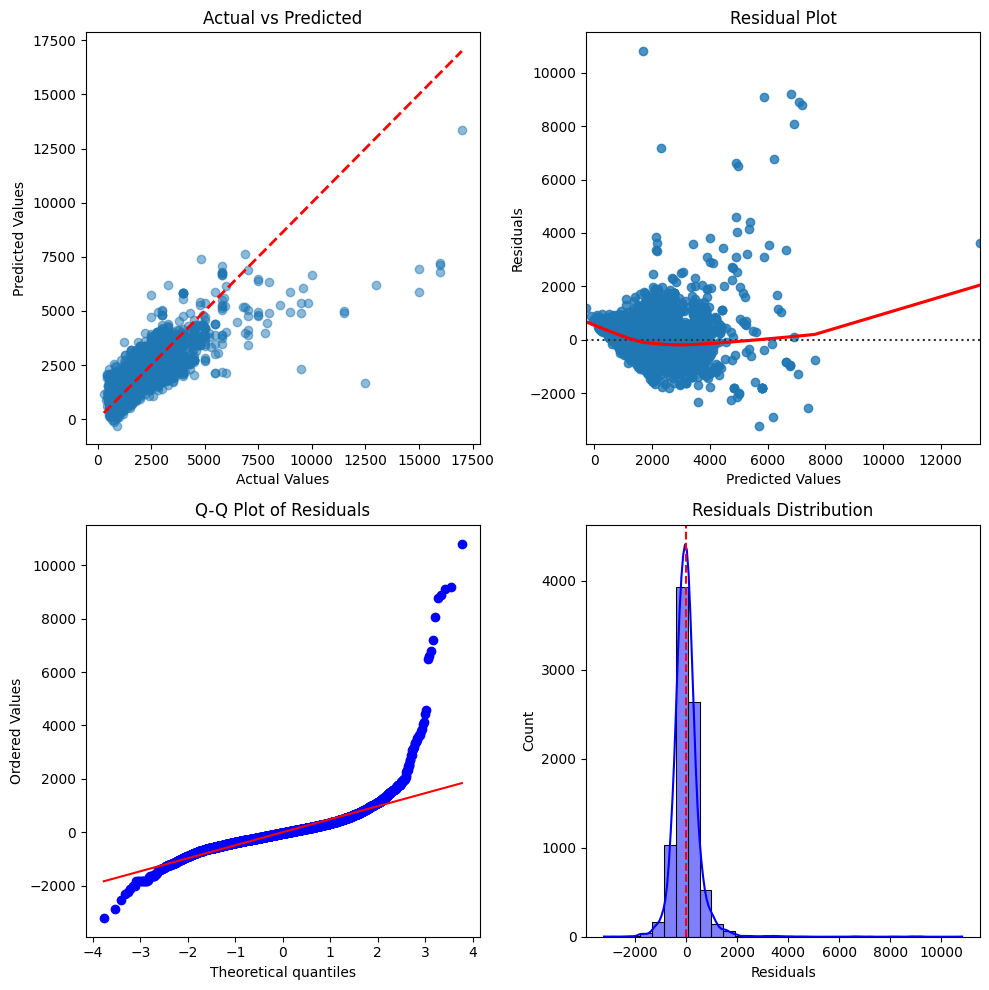

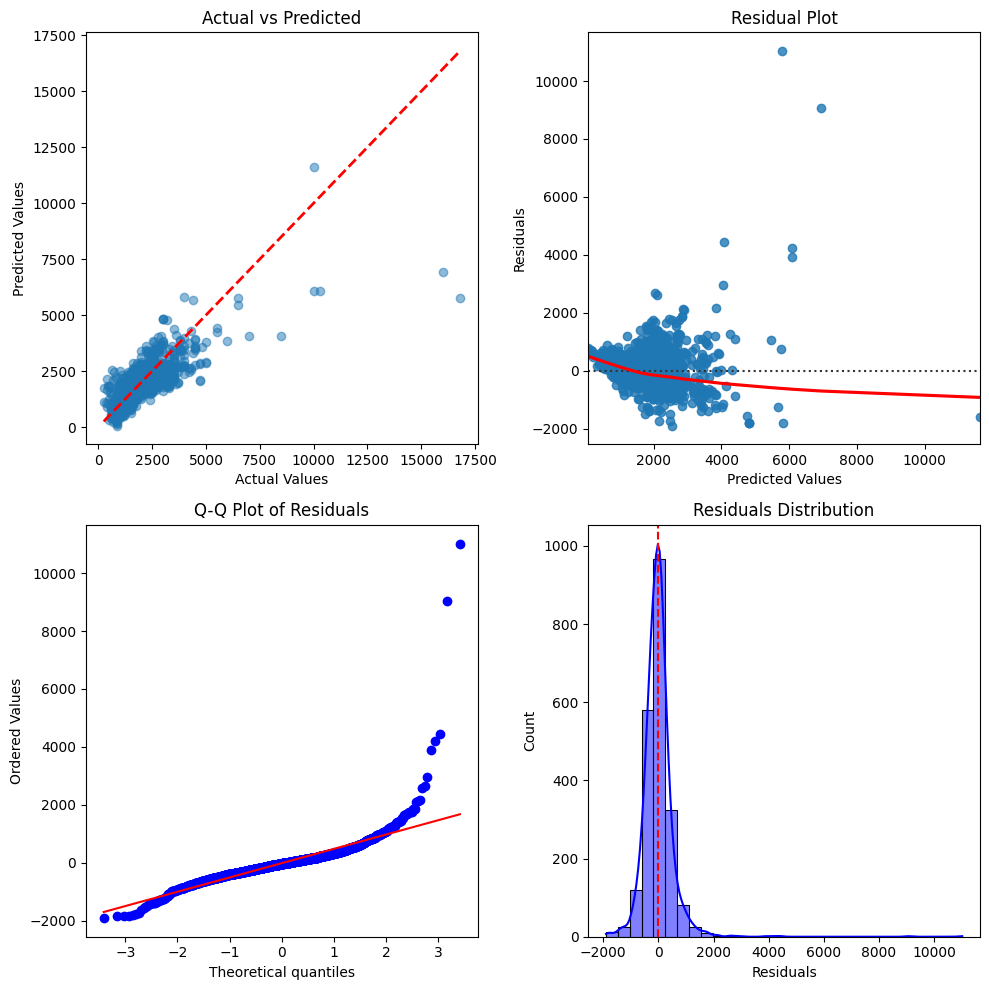

In [166]:
# Make predictions
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Coefficients
print(f'Coefficients: \n{lr_model.coef_}\n')

# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_train, lr_train_pred)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_test, lr_test_pred)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
plot_graphs(y_train, lr_train_pred)
plot_graphs(y_test, lr_test_pred)

### K-Fold Cross Validation

Setup

In [180]:
# Define scaler for numerical columns only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features)
    ],
    remainder='passthrough'
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Setup KFold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

Train

In [181]:
y_true_train_all = []
y_pred_train_all = []
y_true_test_all = []
y_pred_test_all = []

start_time = time.time()
for train_index, test_index in kf.split(X):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit pipeline
    pipeline.fit(X_train, y_train)

    # Predict on train set and test set
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Store actual and predicted values
    y_true_train_all.extend(y_train)
    y_pred_train_all.extend(y_pred_train)
    y_true_test_all.extend(y_test)
    y_pred_test_all.extend(y_pred_test)
end_time = time.time()

training_time = end_time - start_time
print(f"Training Time: {training_time:.4f} seconds")

y_true_train_all = np.array(y_true_train_all)
y_pred_train_all = np.array(y_pred_train_all)
y_true_test_all = np.array(y_true_test_all)
y_pred_test_all = np.array(y_pred_test_all)

Training Time: 17.4937 seconds


Evaluate

Train Set Metrics:
MAE: 341.82973372897965
MSE: 318845.93195244146
RMSE: 564.6644419054926
R2: 0.6332143782890294

Test Set Metrics:
MAE: 343.0111429889112
MSE: 322246.510025466
RMSE: 567.6676052281529
R2: 0.6293025104629189


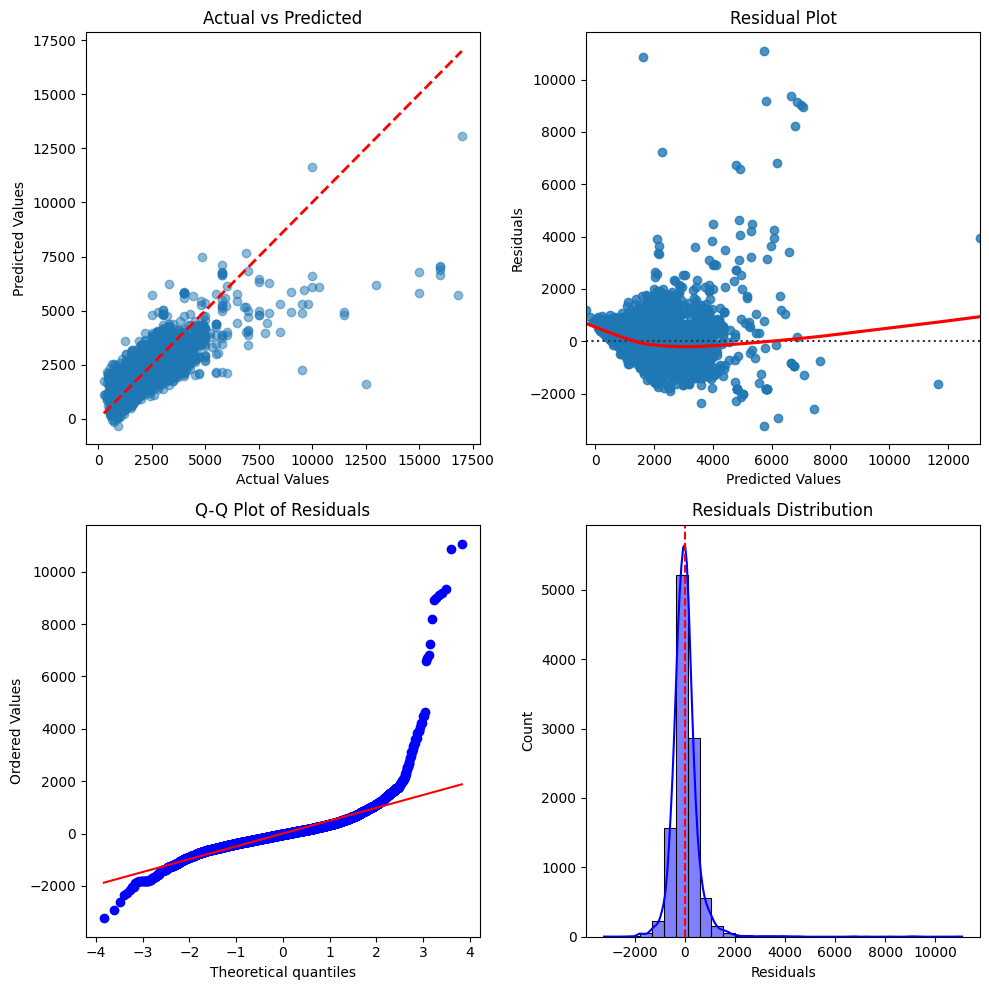

In [182]:
# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_true_train_all, y_pred_train_all)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_true_test_all, y_pred_test_all)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
#plot_graphs(y_true_train_all, y_pred_train_all)
plot_graphs(y_true_test_all, y_pred_test_all)

## Ridge

Setup

In [338]:
# Define scaler for numerical columns only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features)
    ],
    remainder='passthrough'
)

# Setup KFold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Create pipeline
alpha = 0.01
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=alpha))
])

Train

In [339]:
y_true_train_all = []
y_pred_train_all = []
y_true_test_all = []
y_pred_test_all = []

start_time = time.time()
for train_index, test_index in kf.split(X):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit pipeline
    pipeline.fit(X_train, y_train)

    # Predict on train set and test set
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Store actual and predicted values
    y_true_train_all.extend(y_train)
    y_pred_train_all.extend(y_pred_train)
    y_true_test_all.extend(y_test)
    y_pred_test_all.extend(y_pred_test)
end_time = time.time()

training_time = end_time - start_time
print(f"Training Time: {training_time:.4f} seconds")

y_true_train_all = np.array(y_true_train_all)
y_pred_train_all = np.array(y_pred_train_all)
y_true_test_all = np.array(y_true_test_all)
y_pred_test_all = np.array(y_pred_test_all)

Training Time: 0.4451 seconds


Evaluate

In [340]:
# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_true_train_all, y_pred_train_all)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_true_test_all, y_pred_test_all)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
#plot_graphs(y_true_train_all, y_pred_train_all)
#plot_graphs(y_true_test_all, y_pred_test_all)

Train Set Metrics:
MAE: 341.8317478651046
MSE: 318658.7829854847
RMSE: 564.4987006056655
R2: 0.6334296658098

Test Set Metrics:
MAE: 343.33985108677825
MSE: 322770.8029004203
RMSE: 568.1292132080697
R2: 0.6286993881746048


## RidgeCV

Setup

In [257]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler_X = RobustScaler().set_output(transform='pandas')
X_train[num_features] = scaler_X.fit_transform(X_train[num_features])
X_test[num_features] = scaler_X.transform(X_test[num_features])

Train

In [258]:
alphas = np.logspace(-6, 6, 13)
k = 10
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=k)

start_time = time.time()
ridge_cv.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Training Time: {training_time:.4f} seconds")
print('Best Ridge alpha:', ridge_cv.alpha_)
print('Ridge CV RMSE:', np.sqrt(-ridge_cv.best_score_))

Training Time: 1.3990 seconds
Best Ridge alpha: 100.0
Ridge CV RMSE: 566.0165461000075


Evaluate

Train Set Metrics:
MAE: 340.0883367486957
MSE: 315032.70875170856
RMSE: 561.2777465317047
R2: 0.6396295363558271

Test Set Metrics:
MAE: 343.1212472022197
MSE: 335980.1135662982
RMSE: 579.6379159150117
R2: 0.6041094182042201


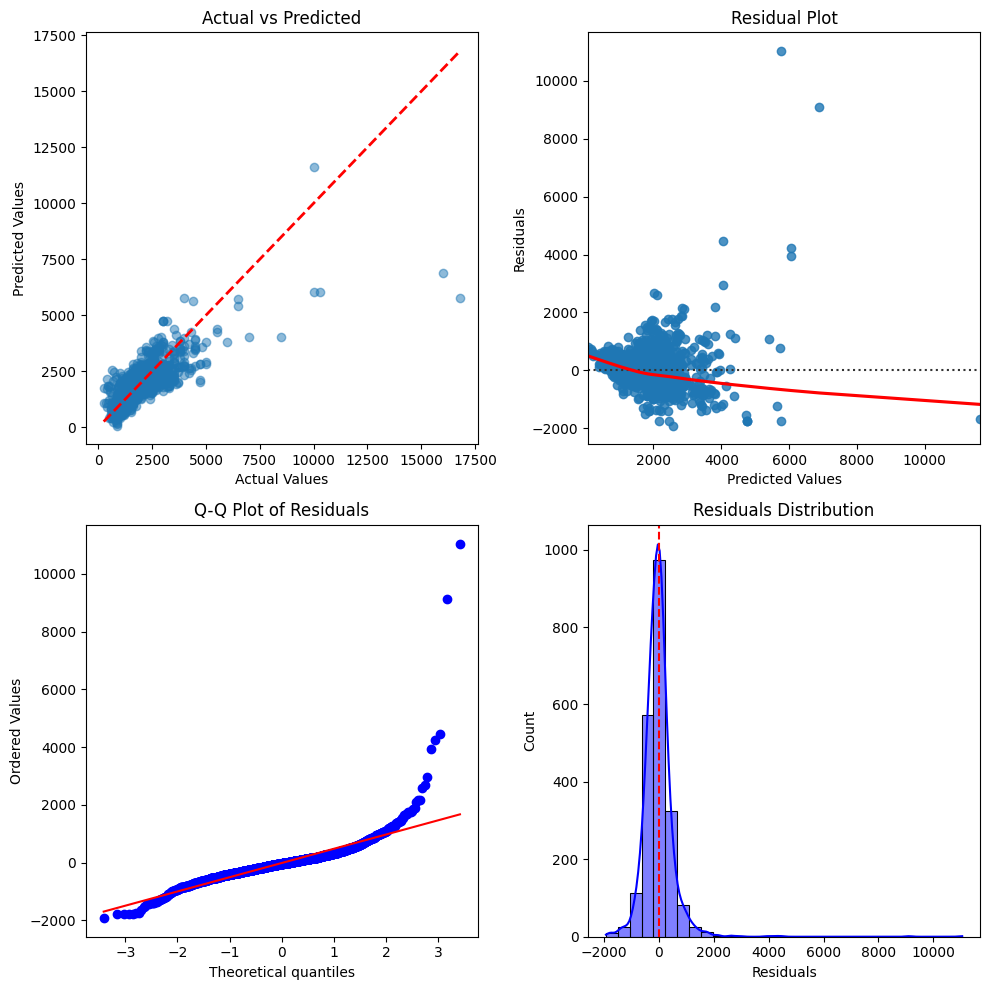

In [259]:
ridge_train_pred = ridge_cv.predict(X_train)
ridge_test_pred = ridge_cv.predict(X_test)

# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_train, ridge_train_pred)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_test, ridge_test_pred)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
plot_graphs(y_test, ridge_test_pred)

## Lasso

Setup

In [293]:
# Define scaler for numerical columns only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features)
    ],
    remainder='passthrough'
)

# Setup KFold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Create pipeline
alpha = 0.01
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=alpha))
])

Train

In [296]:
y_true_train_all = []
y_pred_train_all = []
y_true_test_all = []
y_pred_test_all = []

start_time = time.time()
for train_index, test_index in kf.split(X):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit pipeline
    pipeline.fit(X_train, y_train)

    # Predict on train set and test set
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Store actual and predicted values
    y_true_train_all.extend(y_train)
    y_pred_train_all.extend(y_pred_train)
    y_true_test_all.extend(y_test)
    y_pred_test_all.extend(y_pred_test)
end_time = time.time()

training_time = end_time - start_time
print(f"Training Time: {training_time:.4f} seconds")

y_true_train_all = np.array(y_true_train_all)
y_pred_train_all = np.array(y_pred_train_all)
y_true_test_all = np.array(y_true_test_all)
y_pred_test_all = np.array(y_pred_test_all)

Training Time: 0.6578 seconds


Evaluate

In [297]:
# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_true_train_all, y_pred_train_all)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_true_test_all, y_pred_test_all)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
#plot_graphs(y_true_test_all, y_pred_test_all)

Train Set Metrics:
MAE: 341.8319108417544
MSE: 318658.78298368596
RMSE: 564.4987006040723
R2: 0.6334296658118691

Test Set Metrics:
MAE: 343.3400238126295
MSE: 322770.8295285759
RMSE: 568.1292366430158
R2: 0.6286993575428055


## LassoCV

Setup

In [305]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler_X = RobustScaler().set_output(transform='pandas')
X_train[num_features] = scaler_X.fit_transform(X_train[num_features])
X_test[num_features] = scaler_X.transform(X_test[num_features])

Train

In [306]:
alphas = np.logspace(-6, 6, 13)
k = 10
lasso_cv = LassoCV(alphas=alphas, cv=k)

start_time = time.time()
lasso_cv.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Training Time: {training_time:.4f} seconds")
print('Best Lasso alpha:', lasso_cv.alpha_)

Training Time: 0.1131 seconds
Best Lasso alpha: 0.1


Evaluate

Train Set Metrics:
MAE: 341.5676632900688
MSE: 314855.14116579766
RMSE: 561.1195426696504
R2: 0.6398326584808802

Test Set Metrics:
MAE: 344.22016550656247
MSE: 335797.21615473606
RMSE: 579.4801257633743
R2: 0.6043249290625972


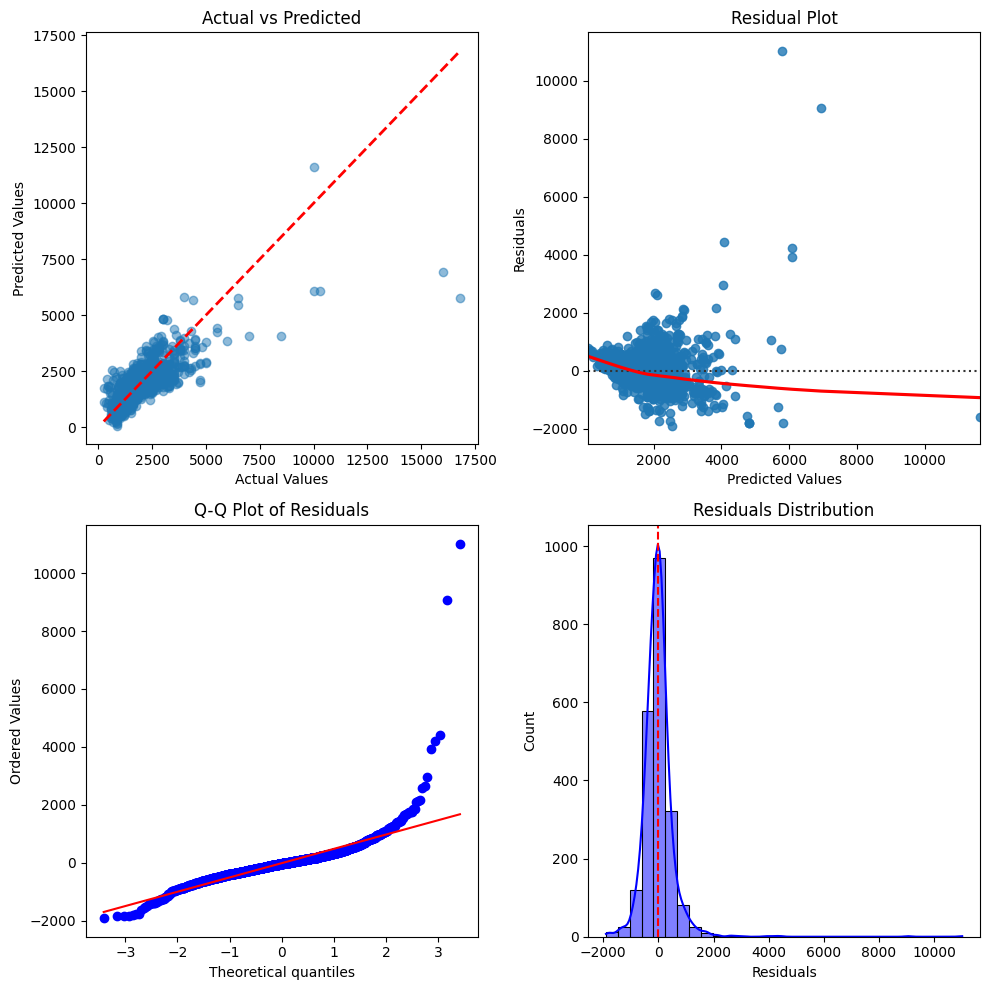

In [307]:
lasso_train_pred = lasso_cv.predict(X_train)
lasso_test_pred = lasso_cv.predict(X_test)

# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_train, lasso_train_pred)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_test, lasso_test_pred)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
plot_graphs(y_test, lasso_test_pred)

## ElasticNet

Setup

In [481]:
# Define scaler for numerical columns only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features)
    ],
    remainder='passthrough'
)

# Setup KFold cross-validation
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Create pipeline
alpha = 0.1
l1_ratio = 0.9
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
])

Train

In [482]:
y_true_train_all = []
y_pred_train_all = []
y_true_test_all = []
y_pred_test_all = []

start_time = time.time()
for train_index, test_index in kf.split(X):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit pipeline
    pipeline.fit(X_train, y_train)

    # Predict on train set and test set
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Store actual and predicted values
    y_true_train_all.extend(y_train)
    y_pred_train_all.extend(y_pred_train)
    y_true_test_all.extend(y_test)
    y_pred_test_all.extend(y_pred_test)
end_time = time.time()

training_time = end_time - start_time
print(f"Training Time: {training_time:.4f} seconds")

y_true_train_all = np.array(y_true_train_all)
y_pred_train_all = np.array(y_pred_train_all)
y_true_test_all = np.array(y_true_test_all)
y_pred_test_all = np.array(y_pred_test_all)

Training Time: 0.5769 seconds


Evaluate

Train Set Metrics:
MAE: 340.4021384947014
MSE: 318821.0589188785
RMSE: 564.6424168612189
R2: 0.6332429910771035

Test Set Metrics:
MAE: 341.8049459022157
MSE: 322690.98196652724
RMSE: 568.0589599386029
R2: 0.6287912104872944


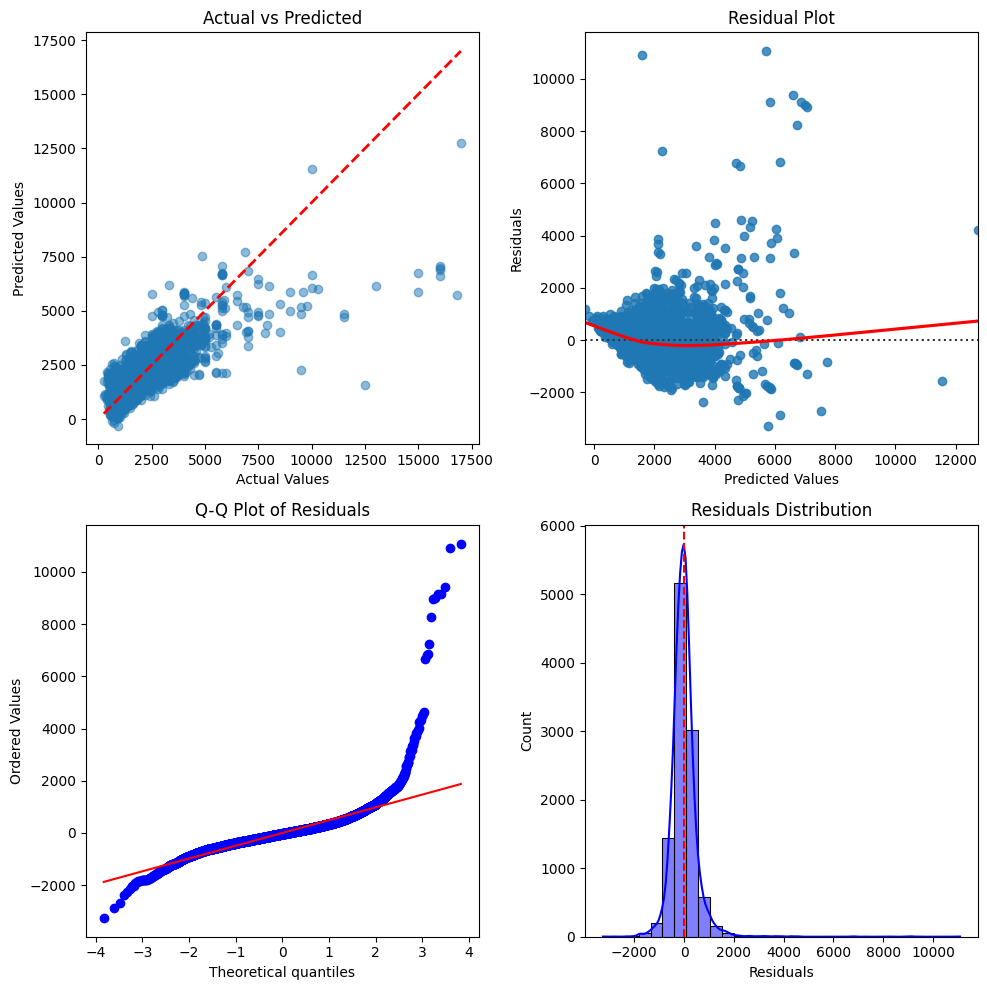

In [483]:
# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_true_train_all, y_pred_train_all)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_true_test_all, y_pred_test_all)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
plot_graphs(y_true_test_all, y_pred_test_all)

## ElasticNetCV

Setup

In [308]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler_X = RobustScaler().set_output(transform='pandas')
X_train[num_features] = scaler_X.fit_transform(X_train[num_features])
X_test[num_features] = scaler_X.transform(X_test[num_features])

Train

In [387]:
alphas = np.logspace(-6, 6, 13)
k = 10
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=k)

start_time = time.time()
elasticnet_cv.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Training Time: {training_time:.4f} seconds")
print('Best ElasticNet alpha:', elasticnet_cv.alpha_)

Training Time: 0.1984 seconds
Best ElasticNet alpha: 0.01


Evaluate

Train Set Metrics:
MAE: 343.9988245784439
MSE: 324606.1534548179
RMSE: 569.7421815653269
R2: 0.6352065104979601

Test Set Metrics:
MAE: 337.7148867026683
MSE: 270286.92600639415
RMSE: 519.8912636373053
R2: 0.6050391450701392


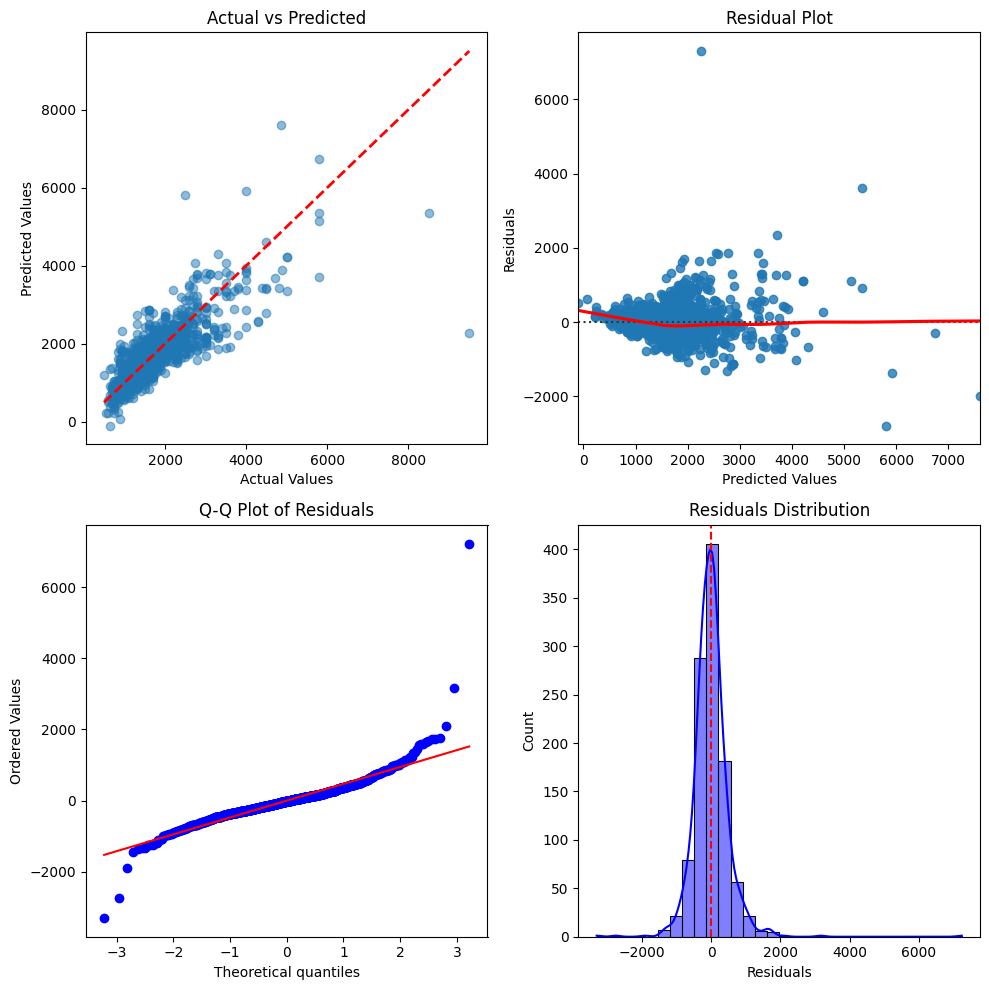

In [388]:
elasticnet_train_pred = elasticnet_cv.predict(X_train)
elasticnet_test_pred = elasticnet_cv.predict(X_test)

# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_train, elasticnet_train_pred)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_test, elasticnet_test_pred)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
plot_graphs(y_test, elasticnet_test_pred)

## ElasticNet with GridSearchCV

Setup

In [521]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Scaler for numerical columns only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features)
    ],
    remainder='passthrough'
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(random_state=RANDOM_STATE))
])

# Hyperparameter grid
param_grid = {
    'model__alpha': np.logspace(-6, 6, 13),
    'model__l1_ratio': np.linspace(0, 1, 11)
}

# Use GridSearchCV for hyperparameter tuning
enet_grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

Hyperparameter tuning

In [522]:
# Fit GridSearchCV
enet_grid_search.fit(X_train, y_train)

c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['rooms',
                                                                          'parking',
                                                                          'bathroom',
                                                                          'size',
                                                                          'age'])])),
                                       ('model', ElasticNet(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                         'model__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error')

In [523]:
# Best parameters
print('Best parameters:', enet_grid_search.best_params_)
print('Best cross-validation score:', np.sqrt(-enet_grid_search.best_score_))

Best parameters: {'model__alpha': np.float64(0.1), 'model__l1_ratio': np.float64(0.9)}
Best cross-validation score: 566.0051370082714


In [524]:
# Extract best model
best_enet = enet_grid_search.best_estimator_

Evaluate

Train Set Metrics:
MAE: 340.21446277085096
MSE: 315012.6962974106
RMSE: 561.2599186628336
R2: 0.6396524288912169

Test Set Metrics:
MAE: 343.215981748021
MSE: 335955.76136697445
RMSE: 579.6169091451477
R2: 0.6041381127785983


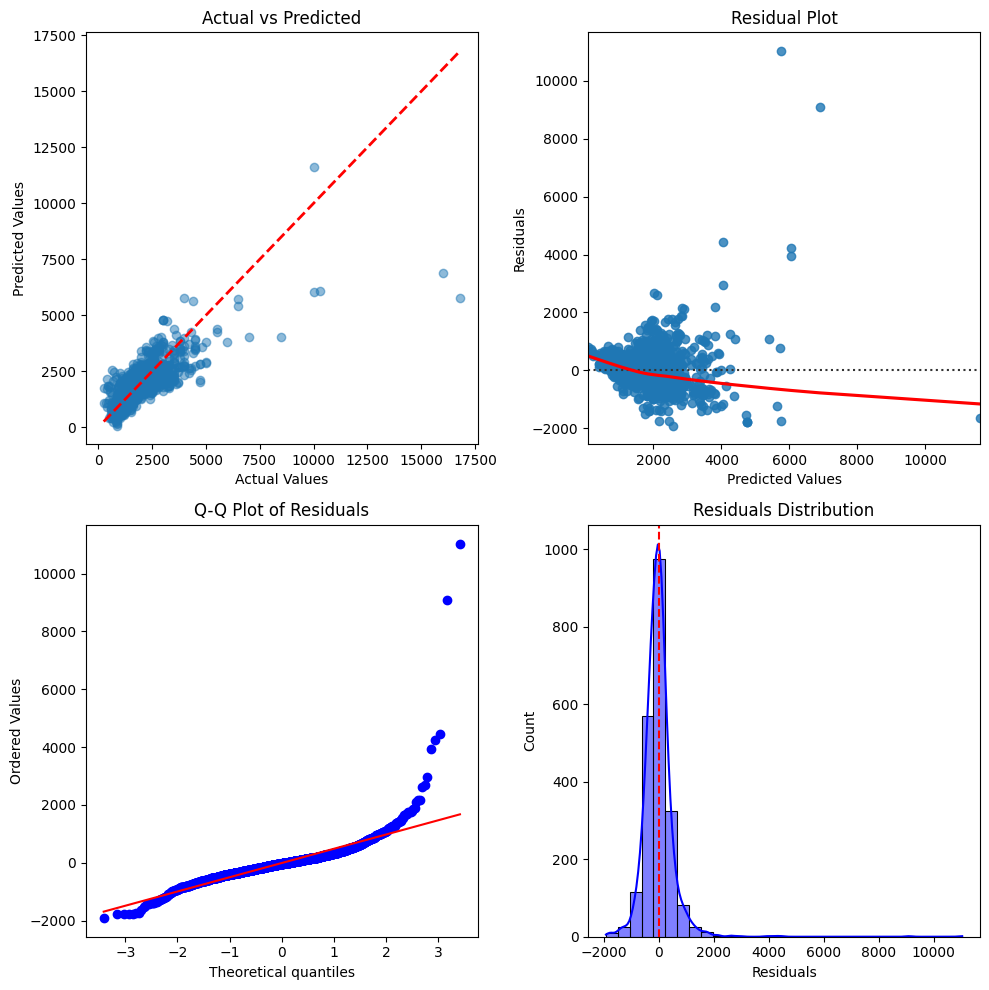

In [527]:
best_enet_train_pred = best_enet.predict(X_train)
best_enet_test_pred = best_enet.predict(X_test)

# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_train, best_enet_train_pred)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_test, best_enet_test_pred)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
plot_graphs(y_test, best_enet_test_pred)

## Reduce Dimensionality

Setup

In [519]:
# Select key features to keep (Filter out facilities and amenities)
X_reduced = X[['size']]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=RANDOM_STATE)

# Scaler for numerical columns only
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_features)
    ],
    remainder='passthrough'
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(random_state=RANDOM_STATE))
])

# Hyperparameter grid
param_grid = {
    'model__alpha': np.logspace(-6, 6, 13),
    'model__l1_ratio': np.linspace(0, 1, 11)
}

# Use GridSearchCV for hyperparameter tuning
enet_reduced_grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

Hyperparameter tuning

In [520]:
# Fit GridSearchCV
enet_reduced_grid.fit(X_train, y_train)

ValueError: 
All the 1430 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1430 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\pandas\core\indexes\base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\\_libs\\hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'rooms'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\utils\_indexing.py", line 361, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\pandas\core\indexes\base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'rooms'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\compose\_column_transformer.py", line 968, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\compose\_column_transformer.py", line 536, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\utils\_indexing.py", line 369, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [516]:
# Best parameters
print('Best parameters:', enet_reduced_grid.best_params_)
print('Best cross-validation score:', np.sqrt(-enet_reduced_grid.best_score_))

Best parameters: {'model__alpha': np.float64(1.0), 'model__l1_ratio': np.float64(1.0)}
Best cross-validation score: 572.0019416754182


In [517]:
# Extract best model
best_enet_reduced = enet_reduced_grid.best_estimator_

Evaluate

Train Set Metrics:
MAE: 347.31532633706803
MSE: 323538.369291639
RMSE: 568.8043330457663
R2: 0.6298997884686308

Test Set Metrics:
MAE: 349.9043302187155
MSE: 341246.1751584215
RMSE: 584.1627985060513
R2: 0.5979043361076968


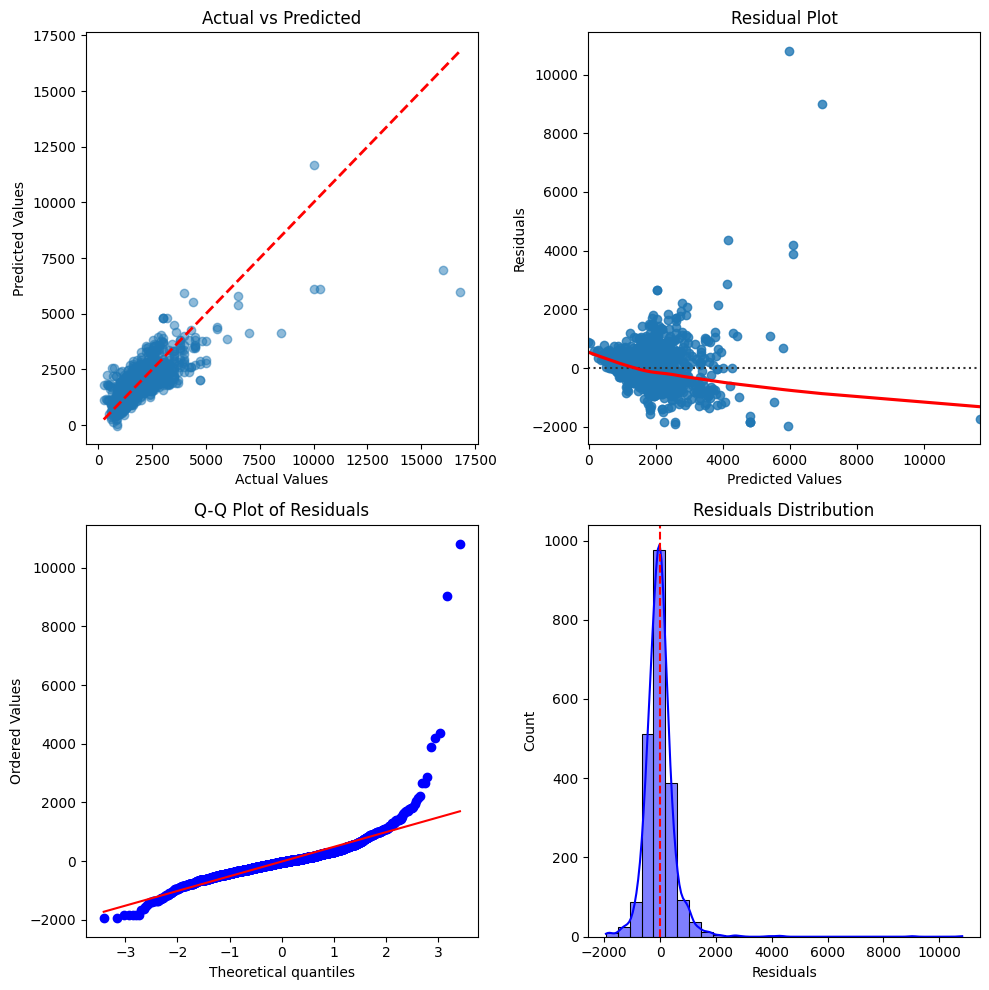

In [518]:
best_enet_train_pred = best_enet_reduced.predict(X_train)
best_enet_test_pred = best_enet_reduced.predict(X_test)

# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_train, best_enet_train_pred)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_test, best_enet_test_pred)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
plot_graphs(y_test, best_enet_test_pred)

# Random Forest Regression

Constants

In [559]:
X = df.drop('monthly_rent', axis=1)  # Features
y = df['monthly_rent']               # Target

k = 10  # Number of folds
RANDOM_STATE = 42   # Fixed RNG seed for reproducible split

Setup

In [560]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# RF hyperparameters
params = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_features': ['sqrt', 'log2']
}

# Initialize RandomForestRegressor
rf_tree = RandomForestRegressor(
    criterion='squared_error',
    random_state=RANDOM_STATE
)

# Use GridSearchCV to perform cross-validated hyperparameter tuning. This finds the best hyperparameters (n_estimators, max_features).
rf_tree_grid = GridSearchCV(
    estimator=rf_tree,
    param_grid=params,
    cv=10,
    scoring='neg_mean_absolute_error'
)

Hyperparameter tuning

In [469]:
# Tune RF model with GridSearchCV
rf_tree_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='neg_mean_absolute_error')

In [470]:
# Best hyperparameters found by GridSearchCV
rf_tree_grid.best_params_

{'max_features': 'sqrt', 'n_estimators': 250}

In [471]:
# Extract best model
best_rf = rf_tree_grid.best_estimator_

Train

In [579]:
# Alternatively, retrain new model
# Initialize new RandomForestRegressor with best hyperparameters
rf_tree = RandomForestRegressor(
    criterion='squared_error',
    max_features='sqrt',
    n_estimators=50,
    random_state=RANDOM_STATE
)

# Train
rf_tree.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=300, random_state=42)

Evaluate

Train Set Metrics:
MAE: 84.02053242813037
MSE: 36143.064963253
RMSE: 190.1132950723147
R2: 0.9586554261938736

Test Set Metrics:
MAE: 206.6292236037298
MSE: 157779.94156068913
RMSE: 397.21523329385184
R2: 0.8140854463166328


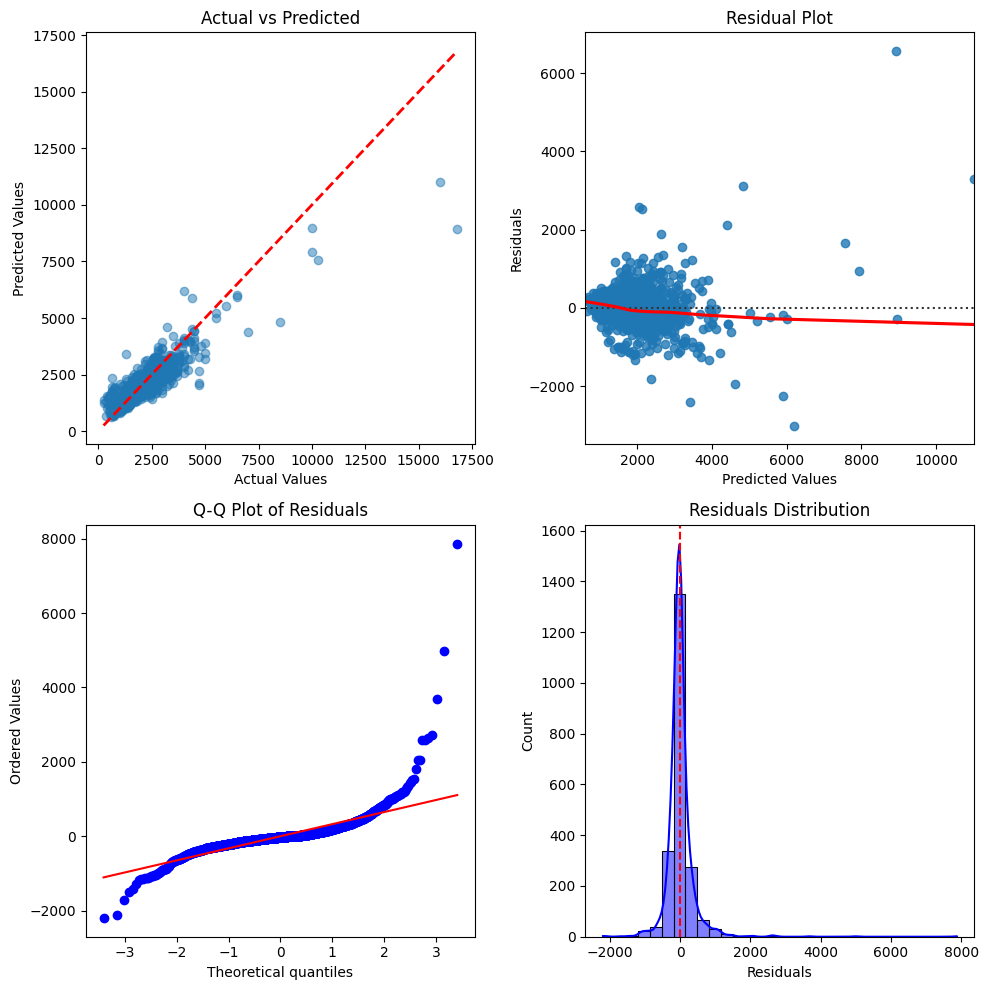

In [580]:
y_train_pred = rf_tree.predict(X_train)
y_test_pred = rf_tree.predict(X_test)

# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_train, y_train_pred)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_test, y_test_pred)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
plot_graphs(y_test, y_test_pred)

# Export

In [526]:
from pickle import dump

model_dir = '../models'
model_name = 'linear_regression_enet.pkl'
model_path = f'{model_dir}/{model_name}'

with open(model_path, "wb") as f:
    dump(best_enet, f, protocol=5)

# Real Predictions

Load model

In [547]:
from pickle import load

model_dir = '../models'

lr_model_name = 'linear_regression_enet.pkl'
lr_model_path = f'{model_dir}/{lr_model_name}'

rf_model_name = 'random_forest_regressor.pkl'
rf_model_path = f'{model_dir}/{rf_model_name}'

# Load LinearRegressor
with open(lr_model_path, "rb") as f:
    lr_model = load(f)

# Load RandomForestRegressor
with open(rf_model_path, "rb") as f:
    rf_model = load(f)

Data configuration

In [530]:
X = df.drop('monthly_rent', axis=1)  # Features
y = df['monthly_rent']               # Target

k = 10  # Number of folds
RANDOM_STATE = 42   # Fixed RNG seed for reproducible split

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

Sanity check

In [548]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Metrics
lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_train, y_train_pred)
print('Train Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(y_test, y_test_pred)
print('\nTest Set Metrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

# Plots
#plot_graphs(y_test, y_test_pred)

Train Set Metrics:
MAE: 87.27602247620305
MSE: 37358.21806552543
RMSE: 193.28274125106316
R2: 0.9572653950171118

Test Set Metrics:
MAE: 207.419901866583
MSE: 152335.7966178429
RMSE: 390.30218628370875
R2: 0.8205003667889382


Property: The Zizz, Damansara Damai Selangor

In [544]:
# Independent variables
data = {
    'location': 1675,
    'property_type': 1650,
    'rooms': 3,
    'parking': 1,
    'bathroom': 2,
    'size': 674,
    'furnished': 2,
    'region': 0,
    'age': 5,
    'missing_parking': 0,
    'f_minimart': 0,
    'f_gymnasium': 1,
    'f_security': 1,
    'f_playground': 1,
    'f_swimming_pool': 1,
    'f_parking': 1,
    'f_lift': 1,
    'f_barbeque_area': 0,
    'f_multipurpose_hall': 0,
    'f_jogging_track': 0,
    'f_squash_court': 0,
    'f_sauna': 1,
    'f_club_house': 0,
    'f_tennis_court': 0,
    'missing_facilities': 0,
    'a_air_cond': 1,
    'a_cooking_allowed': 1,
    'a_washing_machine': 1,
    'a_near_ktm_lrt': 1,
    'a_internet': 0,
    'missing_amenities': 0,
}

# Actual property
prop = pd.DataFrame([data])

# Actual price
actual_price = np.array([1700])

LinearRegressor

In [550]:
pred = lr_model.predict(prop)

print('Predicted Price:', pred)

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(actual_price, pred)
print('\nMetrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

Predicted Price: [1823.04045823]

Metrics:
MAE: 123.04045823453816
MSE: 15138.95436256513
RMSE: 123.04045823453816
R2: nan


c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


RandomForestRegressor

In [549]:
pred = rf_model.predict(prop)

print('Predicted Price:', pred)

lr_mae, lr_mse, lr_rmse, lr_r2 = calculate_metrics(actual_price, pred)
print('\nMetrics:')
print(f'MAE: {lr_mae}')
print(f'MSE: {lr_mse}')
print(f'RMSE: {lr_rmse}')
print(f'R2: {lr_r2}')

Predicted Price: [1731.94]

Metrics:
MAE: 31.940000000000055
MSE: 1020.1636000000035
RMSE: 31.940000000000055
R2: nan


c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
